In [1]:
import os
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

import PIL
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchinfo import summary

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset
# from galaxy_mnist import GalaxyMNIST

from torchvision.datasets import ImageFolder

import torch.nn.functional as TF

from torchvision.transforms import transforms
from torch.utils.data import TensorDataset

import cv2
import torchvision.models as models

In [2]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%pip install git+https://github.com/mwalmsley/galaxy_mnist.git
from galaxy_mnist import GalaxyMNIST
from galaxy_mnist import GalaxyMNISTHighrez


  Cloning https://github.com/mwalmsley/galaxy_mnist.git to /tmp/pip-req-build-2zsy9p3_
  Running command git clone --filter=blob:none --quiet https://github.com/mwalmsley/galaxy_mnist.git /tmp/pip-req-build-2zsy9p3_
  Resolved https://github.com/mwalmsley/galaxy_mnist.git to commit 375e0257bfd41acbcb7ba2e0f33c8c04d0d5beef
  Preparing metadata (setup.py) ... done
  Created wheel for galaxyMNIST: filename=galaxyMNIST-0.1.0-py3-none-any.whl size=17121 sha256=273829eaabdd61c81d0b05eb8b501047c474d9687e5d64c7294462d283107fb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ane3i7f/wheels/5d/66/ad/09ca7d27690e6034ba53ae72c03b6bd30aa5818dc3ffd58e79
Successfully built galaxyMNIST
Note: you may need to restart the kernel to use updated packages.


In [4]:
#  Import galaxyMNIST dataset
tv_dataset = GalaxyMNIST(
    root='ML_DP/gal_mnist',
    download=True,
    train=True  # by default, or False for canonical test set
)

test_dataset = GalaxyMNIST(
    root='ML_DP/gal_mnist',
    download=True,
    train=False  # by default, or False for canonical test set
)

tv_images = tv_dataset.data
tv_labels = tv_dataset.targets

test_images = test_dataset.data
test_labels = test_dataset.targets


# Split in test, validation, train
# images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(tv_images, tv_labels, shuffle=True, test_size=0.25, random_state=123)

# Create PyTorch dataset
train_dataset = TensorDataset(images_train, y_train)
val_dataset = TensorDataset(images_val, y_val)
test_dataset = TensorDataset(test_images, test_labels)

100%|██████████| 68681710/68681710 [00:02<00:00, 30233771.56it/s]


Extracting ML_DP/gal_mnist/GalaxyMNIST/raw/train_dataset.hdf5.gz to ML_DP/gal_mnist/GalaxyMNIST/raw


100%|██████████| 17251325/17251325 [00:00<00:00, 30043198.65it/s]


Extracting ML_DP/gal_mnist/GalaxyMNIST/raw/test_dataset.hdf5.gz to ML_DP/gal_mnist/GalaxyMNIST/raw


In [5]:
%pip install torchsummary 
from torchsummary import summary

Note: you may need to restart the kernel to use updated packages.


In [13]:
VGG_model = models.resnet152(pretrained=True)

# define out classifier
classifier = nn.Sequential(
#    nn.Linear(in_features=25088, out_features=4096),
#    nn.ReLU(),
   nn.Linear(in_features=2048, out_features=512),
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=256),
   nn.ReLU(),
   nn.Linear(in_features=256, out_features=4)
)

# replace model class classifier attribute:
VGG_model.fc = classifier
# print(VGG_model)



for param in VGG_model.named_parameters():
    param.requires_grad = False



# define training function

def train_model(model, train_dataset, val_dataset, test_dataset, device,
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5,
                patience=5):
    model = model.to(device)

    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # set up loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2
                                 , momentum = 0.9 )  # pass in the parameters to be updated and learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)
    
    lear_rate = []
    # Training Loop
    print("Training Start:")
    for epoch in range(epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for i, (images, labels) in enumerate(train_loader):
            # reshape images
            images = images.to(device)
            images = images.float()# reshape: from (128, 1, 28, 28) -> (128, 28 * 28) = (128, 284), move batch to device
            labels = labels.to(device)  # move to device
            # forward
            outputs = model(images)  # forward
#             outputs = TF.softmax(outputs, dim=1)
            _, pred = torch.max(outputs.data, 1)

            cur_train_loss = criterion(outputs, labels)  # loss
            cur_train_acc = (pred == labels).sum().item() / batch_size

            # backward
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

            # loss
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for images, labels in val_loader:
                # calculate validation loss
                images = images.to(device)
                labels = labels.to(device)
                images = images.float()
                
                outputs = model(images)
#                 outputs = TF.softmax(outputs, dim=1)

                # loss
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss
                # acc
                _, pred = torch.max(outputs.data, 1)
               
                val_acc += (pred == labels).sum().item() / batch_size

        # learning schedule step
        scheduler.step()

        # print training feedback
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")

        # update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        lear_rate.append(scheduler.get_last_lr())
#         optim.lr_scheduler.StepLR.print_lr(is_)
    test_acc = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, pred = torch.max(outputs.data, 1)
            test_acc += (pred == labels).sum().item()
            
            lab_pred.extend(pred.cpu().numpy())
            labels = labels.data.cpu().numpy()
            lab_true.extend(labels)
    print(f'Test Accuracy:  {(test_acc / len(test_loader))}')
    
    
    
    return history, lab_true, lab_pred, lear_rate

In [15]:
# Train the CNN model
hist, lab_true, lab_pred, lr = train_model(VGG_model, train_dataset, val_dataset, test_dataset, device, lr=0.01, batch_size=32, epochs=30, l2=0.0001
                   , patience=5)

Training Start:
Epoch:1 / 30, lr: 0.01000 train loss:1.36967, train acc: 0.29904, valid loss:1.37070, valid acc:0.30060
Epoch:2 / 30, lr: 0.01000 train loss:1.35503, train acc: 0.31732, valid loss:1.36161, valid acc:0.31250
Epoch:3 / 30, lr: 0.01000 train loss:1.35555, train acc: 0.30751, valid loss:1.35293, valid acc:0.31151
Epoch:4 / 30, lr: 0.01000 train loss:1.34670, train acc: 0.32497, valid loss:1.34766, valid acc:0.32986
Epoch:5 / 30, lr: 0.00500 train loss:1.34791, train acc: 0.32696, valid loss:1.33882, valid acc:0.33581
Epoch:6 / 30, lr: 0.00500 train loss:1.33918, train acc: 0.33045, valid loss:1.34954, valid acc:0.35218
Epoch:7 / 30, lr: 0.00500 train loss:1.34023, train acc: 0.33677, valid loss:1.33765, valid acc:0.35565
Epoch:8 / 30, lr: 0.00500 train loss:1.33969, train acc: 0.33610, valid loss:1.34174, valid acc:0.35516
Epoch:9 / 30, lr: 0.00500 train loss:1.33766, train acc: 0.33810, valid loss:1.33757, valid acc:0.34772
Epoch:10 / 30, lr: 0.00250 train loss:1.33737, t

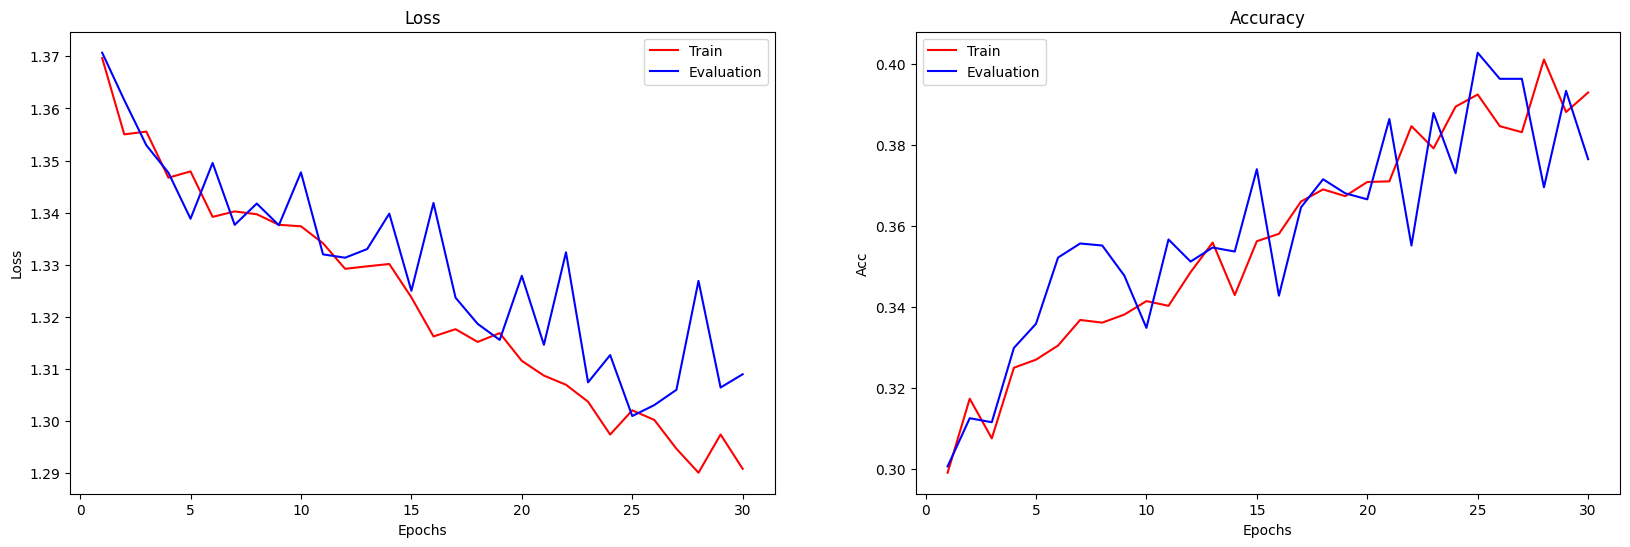

In [16]:
train_loss = torch.tensor(hist['train_loss'])
val_loss = torch.tensor(hist['val_loss'])
train_acc = torch.tensor(hist['train_acc'])
val_acc =  torch.tensor(hist['val_acc'])



# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(epochs, train_loss, 'r-', label='Train')
ax[0].plot(epochs, val_loss , 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, train_acc, 'r-', label='Train')
ax[1].plot(epochs, val_acc , 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

<Axes: >

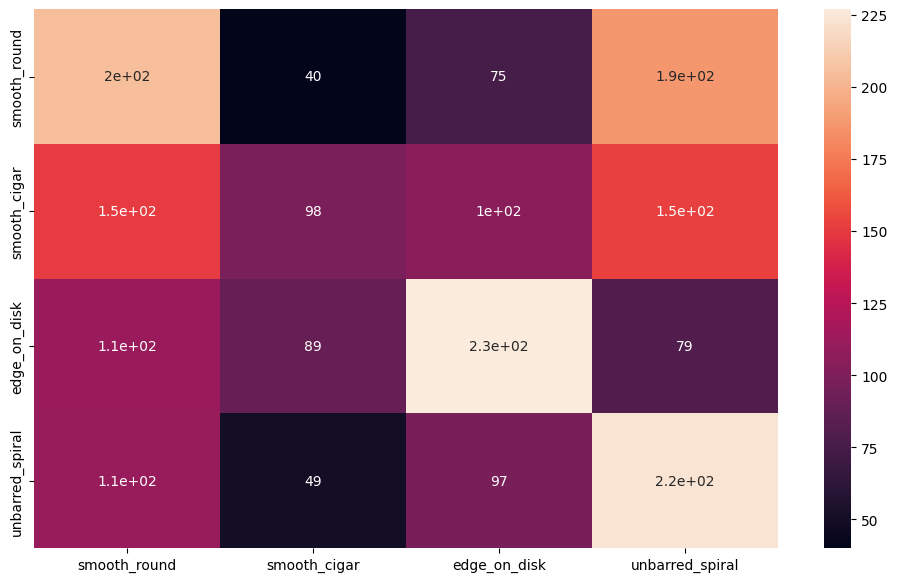

In [17]:
import pandas as pd
cf_matrix = confusion_matrix(lab_true, lab_pred)
classes = GalaxyMNIST.classes
df_cm = pd.DataFrame(cf_matrix 
                     , index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

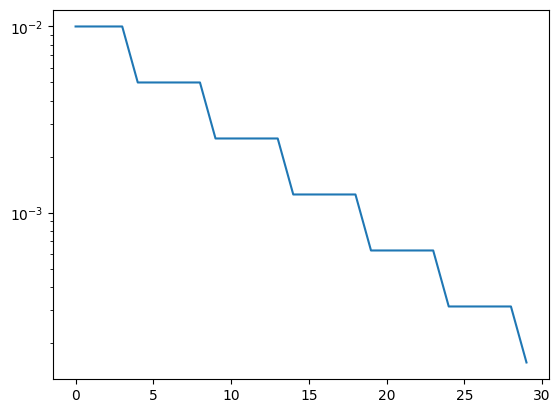

In [12]:
plt.plot(lr)
plt.yscale('log')